In [1]:
# import event simulation files
import sys
sys.path.insert(0, '../../DataGeneration')
import GenEvents as ge
import PlotEvents as pe
import EventData as ed
import Params as ps

In [2]:
import numpy as np
import tqdm 
import math
import matplotlib.pyplot as plt
import csv

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import BinaryConfusionMatrix

import snntorch as snn
from snntorch import spikegen
import snntorch.spikeplot as splt
from snntorch import surrogate
import snntorch.functional as SF

from sklearn.metrics import ConfusionMatrixDisplay

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Data processing

In [3]:
n_evt = 100000
n_evt_test = 5000
n_evt_val = 10000

evt_arr,      muon_list,      max_n      = ge.generate_noisy_evts(n_evt,      noise_frac=0.5, bkg_frac=0.3)
evt_arr_test, muon_list_test, max_n_test = ge.generate_noisy_evts(n_evt_test, noise_frac=0.5, bkg_frac=0.3)
evt_arr_val,  muon_list_val,  max_n_val  = ge.generate_noisy_evts(n_evt_val,  noise_frac=0.5, bkg_frac=0.3)

100%|██████████| 10000/10000 [00:12<00:00, 794.70it/s]


In [4]:
# transform each event (muon_hits list) to np.array of fixed size
def convert_to(muon_list, size, target_dtype, features):
    padded_array = np.zeros(shape=(len(muon_list), size, len(features)), dtype=target_dtype)
    for i, muon_hits in enumerate(muon_list):
        for j, hit in enumerate(muon_hits):
            for k, f in enumerate(features):
                padded_array[i,j,k] = hit[f]  # BEWARE: implicit type conversions going on here

    return torch.tensor(padded_array)

feature_list = ['layer', 'wire_num', 'bx', 't0', 'signal']
mu_arr      = convert_to(muon_list,      size=max_n,      target_dtype=np.float32, features=feature_list)
mu_arr_test = convert_to(muon_list_test, size=max_n_test, target_dtype=np.float32, features=feature_list)
mu_arr_val  = convert_to(muon_list_val,  size=max_n_val,  target_dtype=np.float32, features=feature_list)

In [5]:
def custom_spikegen(data, num_step=40, batch_size=100, linearise=True):

    spike_data = torch.zeros(size=(num_step, batch_size, ps.NLAYERS,ps.NWIRES), dtype=data.dtype)
    for n_batch, evt in enumerate(data):
        for hit in evt:
            layer = int(hit[0])
            wire = int(hit[1])
            bx = int(hit[2])
            t0 = math.floor(hit[3])
            if bx != 0:
                spike_data[bx-t0+ps.bx_oot, n_batch, layer-1, wire-1] = 1
            else:
                break
    if linearise:
        spike_data = spike_data.view(num_step, batch_size, -1)
                
    return spike_data    

In [6]:
def gen_target_cell(muon_list, linearise=True):
    target = np.zeros(shape=(len(muon_list), ps.NLAYERS, ps.NWIRES))
    for i, evt in tqdm.tqdm(enumerate(muon_list)):
        for hit in evt:
            layer, wire = hit['layer']-1, hit['wire_num']-1

            if hit['signal'] == True:
                target[i, layer, wire] = 1
    target = torch.tensor(target, dtype=torch.long)
    if linearise:
        target = target.view(len(muon_list), -1)

    return target

In [7]:
class CustomDataset(Dataset):
    def __init__(self, input_data, target, transform=None):
        self.data = list(zip(input_data, target))
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        sample = self.data[idx]
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample


# Transformations

# converts to Torch tensor of desired type
def to_tensor_and_dtype(input_variable, target_dtype=torch.float32):
    
    # Convert to PyTorch tensor
    if type(input_variable) != torch.Tensor:
        input_variable = torch.tensor(input_variable)
    # Force the tensor to have the specified dtype
    tensor = input_variable.to(target_dtype)
    
    return tensor


transform = transforms.Compose([
    lambda x: (to_tensor_and_dtype(x[0], target_dtype=torch.float32), x[1])
])

In [8]:
target      = gen_target_cell(muon_list)
target_test = gen_target_cell(muon_list_test)
target_val  = gen_target_cell(muon_list_val)

train_dataset = CustomDataset(mu_arr,      target,      transform=transform)
test_dataset  = CustomDataset(mu_arr_test, target_test, transform=transform)
val_dataset   = CustomDataset(mu_arr_val,  target_val,  transform=transform)

batch_size = 100
nw=0

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=nw)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=nw)

100000it [00:00, 248408.26it/s]
5000it [00:00, 277750.08it/s]
10000it [00:00, 303069.79it/s]


## Network definitions

In [9]:
class Net_LIF_1L(nn.Module):
    """FCN with 1 hidden layer and LIF neurons."""

    def __init__(self, input_feat, hidden, out_feat, timesteps,
                 learnable, beta=0.8, threshold=1.0):
        super().__init__()
        
        self.input_feat = input_feat          # number of input neurons 
        self.hidden = hidden                  # number of hidden neurons
        self.out_feat = out_feat              # number of output neurons
        
        self.timesteps = timesteps            # number of time steps to simulate the network

        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        
        self.fc_in = nn.Linear(in_features=self.input_feat, out_features=self.hidden)
        self.lif_in = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=threshold,
                                learn_beta=learnable, learn_threshold=learnable)
        
        self.fc_out = nn.Linear(in_features=self.hidden, out_features=self.out_feat)
        self.lif_out = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=threshold,
                                 learn_beta=learnable, learn_threshold=learnable)
    
    def forward(self, x):
        """Forward pass for several time steps."""

        # Initalize membrane potential
        mem1 = self.lif_in.init_leaky()
        mem2 = self.lif_out.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):
                
            cur1 = self.fc_in(x[step])
            spk1, mem1 = self.lif_in(cur1, mem1)
            cur2 = self.fc_out(spk1)
            spk2, mem2 = self.lif_out(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [10]:
class Net_Syn_1L(nn.Module):
    """FCN with 1 hidden layer and Synaptic neurons."""

    def __init__(self, input_feat, hidden, out_feat, timesteps,
                 learnable, beta=0.8, threshold=1.0, alpha=0.8):
        super().__init__()
        
        self.input_feat = input_feat          # number of input neurons 
        self.hidden = hidden                  # number of hidden neurons
        self.out_feat = out_feat              # number of output neurons
        
        self.timesteps = timesteps            # number of time steps to simulate the network
        
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        
        self.fc_in = nn.Linear(in_features=self.input_feat, out_features=self.hidden)
        self.lif_in = snn.Synaptic(beta=beta, alpha=alpha, threshold=threshold,
                                   spike_grad=spike_grad,
                                   learn_beta=learnable, learn_threshold=learnable, learn_alpha=learnable)
        
        self.fc_out = nn.Linear(in_features=self.hidden, out_features=self.out_feat)
        self.lif_out = snn.Synaptic(beta=beta, alpha=alpha, threshold=threshold,
                                    spike_grad=spike_grad,
                                    learn_beta=learnable, learn_threshold=learnable, learn_alpha=learnable)
    
    def forward(self, x):
        """Forward pass for several time steps."""

        # Initalize membrane potential
        syn1, mem1 = self.lif_in.init_synaptic()
        syn2, mem2 = self.lif_out.init_synaptic()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):
            cur1 = self.fc_in(x[step])
            spk1, syn1, mem1 = self.lif_in(cur1, syn1, mem1)
            
            cur2 = self.fc_out(spk1)
            spk2, syn2, mem2 = self.lif_out(cur2, syn2, mem2)
            
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [11]:
class Net_Syn_3L(nn.Module):
    """FCN with 3 hidden layers and Synaptic neurons."""

    def __init__(self, input_feat, hidden, out_feat, timesteps,
                 learnable, beta=0.8, threshold=1.0, alpha=0.8):
        super().__init__()
        
        self.input_feat = input_feat          # number of input neurons 
        self.hidden = hidden                  # number of hidden neurons
        self.out_feat = out_feat              # number of output neurons
        
        self.timesteps = timesteps            # number of time steps to simulate the network

        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        
        self.fc_in = nn.Linear(in_features=self.input_feat, out_features=self.hidden[0])
        self.lif_in = snn.Synaptic(beta=beta, alpha=alpha, threshold=threshold,
                                   spike_grad=spike_grad,
                                   learn_beta=learnable, learn_threshold=learnable, learn_alpha=learnable)
        
        self.fc_hidden1 = nn.Linear(in_features=self.hidden[0], out_features=self.hidden[1])
        self.lif_hidden1 = snn.Synaptic(beta=beta, alpha=alpha, threshold=threshold,
                                        spike_grad=spike_grad,
                                        learn_beta=learnable, learn_threshold=learnable, learn_alpha=learnable)
        
        self.fc_hidden2 = nn.Linear(in_features=self.hidden[1], out_features=self.hidden[2])
        self.lif_hidden2 = snn.Synaptic(beta=beta, alpha=alpha, threshold=threshold,
                                        spike_grad=spike_grad,
                                        learn_beta=learnable, learn_threshold=learnable, learn_alpha=learnable)
        
        self.fc_out = nn.Linear(in_features=self.hidden[2], out_features=self.out_feat)
        self.lif_out = snn.Synaptic(beta=beta, alpha=alpha, threshold=threshold,
                                    spike_grad=spike_grad,
                                    learn_beta=learnable, learn_threshold=learnable, learn_alpha=learnable)
        
    def forward(self, x):
        """Forward pass for several time steps."""

        # Initalize membrane potential
        syn1, mem1 = self.lif_in.init_synaptic()
        synh1, memh1 = self.lif_hidden1.init_synaptic()
        synh2, memh2 = self.lif_hidden2.init_synaptic()
        syn2, mem2 = self.lif_out.init_synaptic()
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):
            cur1 = self.fc_in(x[step])
            spk1, syn1, mem1 = self.lif_in(cur1, syn1, mem1)
            
            curh1 = self.fc_hidden1(spk1)
            spkh1, synh1, memh1 = self.lif_hidden1(curh1, synh1, memh1)
            
            curh2 = self.fc_hidden2(spkh1)
            spkh2, synh2, memh2 = self.lif_hidden2(curh2, synh2, memh2)
            
            cur2 = self.fc_out(spkh2)
            spk2, syn2, mem2 = self.lif_out(cur2, syn2, mem2)
            
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

## Accuracy and Training Functions

In [12]:
class Multi_loss(nn.Module):
    def __init__(self, n_classes, loss_func, timing):
        super(Multi_loss, self).__init__()
        self.n_classes = n_classes
        self.loss = loss_func
        self.timing = timing

    def forward(self, inputs, targets):
        loss = 0
        for i in range(inputs.shape[-1]//self.n_classes):
            if self.timing:
                loss += self.loss(inputs[:, :, i*self.n_classes:(i+1)*self.n_classes],
                                  targets[:, :, i])
            else:
                loss += self.loss(inputs[:, :, i*self.n_classes:(i+1)*self.n_classes],
                                  targets[:, i])
        return loss

In [13]:
def comp_accuracy(output, targets, type):
    total = 0
    correct = 0
    predicted = None

    # whole chamber classification
    if type == 'chamber':
        _, predicted = output.sum(dim=0).max(1)
        total = targets.size(0)
        correct = (predicted == targets).sum().item()

    # cell-by-cell classification
    elif type == 'cell':
        batch_size = targets.size(0)
        _, predicted = output.sum(dim=0).view(batch_size, ps.NLAYERS*ps.NWIRES, -1).max(2)
        total = targets.numel()
        correct = (predicted == targets).sum().item()

    # accuracy on the whole event for cell-by-cell classification
    elif type == 'cell_per_evt':
        batch_size = targets.size(0)
        total = batch_size
        _, predicted = output.sum(dim=0).view(batch_size, ps.NLAYERS*ps.NWIRES, -1).max(2)
        for i in range(batch_size):
            correct += torch.sum((predicted[i] == targets[i]).all())

    # accuracy cell-by-cell moment-by-moment for precise timing recontruction
    # (MSE loss)
    elif type == 'mse_timing':
        total = targets.numel()
        correct = (output == targets).sum().item()
        predicted = output

    # accuracy on the whole event for timing reconstruction
    # (MSE loss)
    elif type == 'mse_timing_per_evt':
        batch_size = targets.size(1)
        total = batch_size
        for i in range(batch_size):
            correct += torch.sum((output[:, i] == targets[:, i]).all())
        predicted = output

    # accuracy cell-by-cell moment-by-moment for precise timing recontruction
    # (CEMRL)
    elif type == "ce_timing":
        num_steps = targets.size(0)
        batch_size = targets.size(1)
        total = targets.numel()
        _, predicted = output.view(num_steps, batch_size, ps.NLAYERS*ps.NWIRES, -1).max(3)
        correct = (predicted == targets).sum().item()

    # accuracy on the whole event for timing reconstruction
    # (CEMRL)
    elif type == "ce_timing_per_evt":
        num_steps = targets.size(0)
        batch_size = targets.size(1)
        total = batch_size
        _, predicted = output.view(num_steps, batch_size, ps.NLAYERS*ps.NWIRES, -1).max(3)
        for i in range(batch_size):
            correct += torch.sum((predicted[:, i] == targets[:, i]).all())

    # accuracy cell-by-cell moment-by-moment for precise timing recontruction
    # (BCEMRL)
    elif type == "bce_timing":
        total = targets.numel()
        sigmoid = nn.Sigmoid()
        predicted = sigmoid(output)
        predicted[predicted <  0.5] = 0
        predicted[predicted >= 0.5] = 1
        correct = (predicted == targets).sum().item()

    # accuracy on the whole event for timing reconstruction
    # (BCEMRL)
    elif type == "bce_timing_per_evt":
        batch_size = targets.size(1)
        total = batch_size
        sigmoid = nn.Sigmoid()
        predicted = sigmoid(output)
        predicted[predicted <  0.5] = 0
        predicted[predicted >= 0.5] = 1
        for i in range(batch_size):
            correct += torch.sum((predicted[:, i] == targets[:, i]).all())
   

    return total, correct, predicted

In [14]:
def accuracy_set(net, data_loader, loss_fn, accuracy_type, num_steps,
                 batch_size, CM, timing, linearise, use_membrane):
    bcm = BinaryConfusionMatrix()
    net.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        temp_loss = []
        cm = torch.tensor([[0,0],[0,0]])
        for data, targets in data_loader:
            data = data.to(device)
            targets = targets.to(device)

            # create spike train
            spike_in = custom_spikegen(data, num_steps, batch_size, linearise)
            spike_in = spike_in.to(device)
            if timing:
                targets = custom_spikegen(targets, num_steps, batch_size, linearise).type(torch.long)

            # forward pass
            spk_rec, mem_rec = net(spike_in)
            output = None
            if use_membrane:
                output = mem_rec
            else:
                output = spk_rec

            # compute loss
            loss = loss_fn(output, targets)
            temp_loss.append(loss.item())

            # calculate total accuracy
            tot, corr, pred = comp_accuracy(output, targets, accuracy_type)
            total += tot
            correct += corr
            if CM:
                cm += bcm(pred, targets)

        mean_loss = np.mean(temp_loss)
        acc = correct/total
        if CM:
            cm = cm/cm.sum()

        return mean_loss, acc, cm

In [15]:
def F1_score(cm):
    TP = cm[1,1]
    FP = cm[0,1]
    FN = cm[1,0]
    precision = TP/(TP + FP)
    recall = TP/(TP + FN)

    f1 = 2*precision*recall/(precision+recall)
    if math.isnan(f1):
        f1 = 0

    return f1

In [16]:
def train_net(net, train_loader, val_loader, num_epochs, loss_fn, optimizer, accuracy_type,
              num_steps, batch_size, linearise=True, timing=False, use_membrane=False):

    net.to(device)
    
    loss_hist = []
    loss_val_hist = []
    acc_val_hist = []

    iter_counter = 0

    # Validation
    mean_loss_val, acc_val, _ = accuracy_set(net, val_loader, loss_fn, accuracy_type, num_steps,
                                             batch_size, False, timing, linearise, use_membrane)

    loss_val_hist.append(mean_loss_val)
    acc_val_hist.append(acc_val)
    print(f"Validation Set Loss: {mean_loss_val}")
    print(f"Validation Set Accuracy: {100 *acc_val:.2f}%")
    print("\n--------------------------------------------------\n")

    for epoch in range(num_epochs):
        net.train()
        batch_counter = 0
        # Minibatch training loop
        for data, targets in train_loader:
            data = data.to(device)
            targets = targets.to(device)

            # create spike train
            spike_in = custom_spikegen(data, num_steps, batch_size, linearise)
            spike_in = spike_in.to(device)
            if timing:
                targets = custom_spikegen(targets, num_steps, batch_size, linearise).type(torch.long)

            # forward pass
            spk_rec, mem_rec = net(spike_in)
            output = None
            if use_membrane:
                output = mem_rec
            else:
                output = spk_rec

            # compute loss
            loss_val = loss_fn(output, targets)
        
            # Gradient calculation + weight update
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            # Store loss history for future plotting
            loss_hist.append(loss_val.item())
        
            if iter_counter % 50 == 0:
                print("Epoch:", epoch+1)
                print("Batch:", batch_counter)
                print("Iteration:", iter_counter)
                print("Loss:", loss_val.item(),"\n")
        
            batch_counter += 1
            iter_counter += 1

        # Validation
        mean_loss_val, acc_val, _ = accuracy_set(net, val_loader, loss_fn, accuracy_type, num_steps,
                                                 batch_size, False, timing, linearise, use_membrane)

        loss_val_hist.append(mean_loss_val)
        acc_val_hist.append(acc_val)
        print(f"Validation Set Loss: {mean_loss_val}")
        print(f"Validation Set Accuracy: {100 *acc_val:.2f}%")
        print("\n--------------------------------------------------\n")

    return loss_hist, loss_val_hist, acc_val_hist

## Networks Training

In [17]:
num_inputs  = ps.NLAYERS*ps.NWIRES
num_outputs = 2*num_inputs
num_steps   = 40

num_epochs = 10
accuracy_type = 'cell_per_evt'
loss_fn = Multi_loss(2, SF.ce_count_loss(), False)

In [18]:
# Network Architecture 1
num_hidden1 = 100
learn1      = False
beta1       = 0.8
threshold1  = 0.9

net1 = Net_LIF_1L(num_inputs, num_hidden1, num_outputs, num_steps,
                  learn1, beta1, threshold1).to(device)
optimizer1 = torch.optim.Adam(net1.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist1, loss_val_hist1, acc_val_hist1 = train_net(net1,
                                                      train_loader, val_loader,
                                                      num_epochs, loss_fn, optimizer1,
                                                      accuracy_type, num_steps, batch_size,
                                                      True, False, False)

Validation Set Loss: 11.090605812072754
Validation Set Accuracy: 30.42%

--------------------------------------------------

Epoch: 1
Batch: 0
Iteration: 0
Loss: 11.090357780456543 

Epoch: 1
Batch: 50
Iteration: 50
Loss: 10.391894340515137 

Epoch: 1
Batch: 100
Iteration: 100
Loss: 7.5257158279418945 

Epoch: 1
Batch: 150
Iteration: 150
Loss: 6.562998294830322 

Epoch: 1
Batch: 200
Iteration: 200
Loss: 5.0369462966918945 

Epoch: 1
Batch: 250
Iteration: 250
Loss: 4.275744915008545 

Epoch: 1
Batch: 300
Iteration: 300
Loss: 3.954569101333618 

Epoch: 1
Batch: 350
Iteration: 350
Loss: 3.2345025539398193 

Epoch: 1
Batch: 400
Iteration: 400
Loss: 2.860243320465088 

Epoch: 1
Batch: 450
Iteration: 450
Loss: 2.4582161903381348 

Epoch: 1
Batch: 500
Iteration: 500
Loss: 2.352262258529663 

Epoch: 1
Batch: 550
Iteration: 550
Loss: 2.1278815269470215 

Epoch: 1
Batch: 600
Iteration: 600
Loss: 1.9279624223709106 

Epoch: 1
Batch: 650
Iteration: 650
Loss: 1.8806419372558594 

Epoch: 1
Batch: 70

In [19]:
# Network Architecture 2
num_hidden2 = [20,20,20]
learn2      = False
beta2       = 0.8
threshold2  = 0.9
alpha2      = 0.8

net2 = Net_Syn_3L(num_inputs, num_hidden2, num_outputs, num_steps,
                  learn2, beta2, threshold2, alpha2).to(device)
optimizer2 = torch.optim.Adam(net2.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist2, loss_val_hist2, acc_val_hist2 = train_net(net2,
                                                      train_loader, val_loader,
                                                      num_epochs, loss_fn, optimizer2,
                                                      accuracy_type, num_steps, batch_size,
                                                      True, False, False)

Validation Set Loss: 142.22285797119142
Validation Set Accuracy: 0.00%

--------------------------------------------------

Epoch: 1
Batch: 0
Iteration: 0
Loss: 146.14117431640625 

Epoch: 1
Batch: 50
Iteration: 50
Loss: 21.845552444458008 

Epoch: 1
Batch: 100
Iteration: 100
Loss: 9.368720054626465 

Epoch: 1
Batch: 150
Iteration: 150
Loss: 6.7617106437683105 

Epoch: 1
Batch: 200
Iteration: 200
Loss: 5.677499771118164 

Epoch: 1
Batch: 250
Iteration: 250
Loss: 5.271274089813232 

Epoch: 1
Batch: 300
Iteration: 300
Loss: 4.5494513511657715 

Epoch: 1
Batch: 350
Iteration: 350
Loss: 4.975993633270264 

Epoch: 1
Batch: 400
Iteration: 400
Loss: 4.216116428375244 

Epoch: 1
Batch: 450
Iteration: 450
Loss: 4.320106506347656 

Epoch: 1
Batch: 500
Iteration: 500
Loss: 3.6909737586975098 

Epoch: 1
Batch: 550
Iteration: 550
Loss: 3.2525157928466797 

Epoch: 1
Batch: 600
Iteration: 600
Loss: 3.0658628940582275 

Epoch: 1
Batch: 650
Iteration: 650
Loss: 4.008533477783203 

Epoch: 1
Batch: 700
I

In [20]:
# Network Architecture 3
num_hidden3 = 30
learn3      = False
beta3       = 0.8
threshold3  = 0.9

net3 = Net_LIF_1L(num_inputs, num_hidden3, num_outputs, num_steps,
                  learn3, beta3, threshold3).to(device)
optimizer3 = torch.optim.Adam(net3.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist3, loss_val_hist3, acc_val_hist3 = train_net(net3,
                                                      train_loader, val_loader,
                                                      num_epochs, loss_fn, optimizer3,
                                                      accuracy_type, num_steps, batch_size,
                                                      True, False, False)

Validation Set Loss: 11.948391180038453
Validation Set Accuracy: 0.00%

--------------------------------------------------

Epoch: 1
Batch: 0
Iteration: 0
Loss: 11.996533393859863 

Epoch: 1
Batch: 50
Iteration: 50
Loss: 10.411004066467285 

Epoch: 1
Batch: 100
Iteration: 100
Loss: 9.98383903503418 

Epoch: 1
Batch: 150
Iteration: 150
Loss: 9.092306137084961 

Epoch: 1
Batch: 200
Iteration: 200
Loss: 7.227906227111816 

Epoch: 1
Batch: 250
Iteration: 250
Loss: 6.690197944641113 

Epoch: 1
Batch: 300
Iteration: 300
Loss: 5.533150672912598 

Epoch: 1
Batch: 350
Iteration: 350
Loss: 5.449933052062988 

Epoch: 1
Batch: 400
Iteration: 400
Loss: 4.908985614776611 

Epoch: 1
Batch: 450
Iteration: 450
Loss: 4.539463043212891 

Epoch: 1
Batch: 500
Iteration: 500
Loss: 4.097996234893799 

Epoch: 1
Batch: 550
Iteration: 550
Loss: 3.420154333114624 

Epoch: 1
Batch: 600
Iteration: 600
Loss: 3.2593584060668945 

Epoch: 1
Batch: 650
Iteration: 650
Loss: 3.054837942123413 

Epoch: 1
Batch: 700
Iterat

In [21]:
# Network Architecture 4
num_hidden4 = 100
learn4      = False
beta4       = 0.5
threshold4  = 0.9

net4 = Net_LIF_1L(num_inputs, num_hidden4, num_outputs, num_steps,
                  learn4, beta4, threshold4).to(device)
optimizer4 = torch.optim.Adam(net4.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist4, loss_val_hist4, acc_val_hist4 = train_net(net4,
                                                      train_loader, val_loader,
                                                      num_epochs, loss_fn, optimizer4,
                                                      accuracy_type, num_steps, batch_size,
                                                      True, False, False)

Validation Set Loss: 11.090357780456543
Validation Set Accuracy: 30.42%

--------------------------------------------------

Epoch: 1
Batch: 0
Iteration: 0
Loss: 11.090357780456543 

Epoch: 1
Batch: 50
Iteration: 50
Loss: 11.090357780456543 

Epoch: 1
Batch: 100
Iteration: 100
Loss: 11.090357780456543 

Epoch: 1
Batch: 150
Iteration: 150
Loss: 10.746516227722168 

Epoch: 1
Batch: 200
Iteration: 200
Loss: 7.5802001953125 

Epoch: 1
Batch: 250
Iteration: 250
Loss: 6.3467020988464355 

Epoch: 1
Batch: 300
Iteration: 300
Loss: 5.771083831787109 

Epoch: 1
Batch: 350
Iteration: 350
Loss: 5.333438873291016 

Epoch: 1
Batch: 400
Iteration: 400
Loss: 4.947464942932129 

Epoch: 1
Batch: 450
Iteration: 450
Loss: 3.9358983039855957 

Epoch: 1
Batch: 500
Iteration: 500
Loss: 3.170759916305542 

Epoch: 1
Batch: 550
Iteration: 550
Loss: 2.8352484703063965 

Epoch: 1
Batch: 600
Iteration: 600
Loss: 3.264580726623535 

Epoch: 1
Batch: 650
Iteration: 650
Loss: 2.687218189239502 

Epoch: 1
Batch: 700
It

In [22]:
# Network Architecture 5
num_hidden5 = 100
learn5      = False
beta5       = 0.8
threshold5  = 0.9
alpha5      = 0.8

net5 = Net_Syn_1L(num_inputs, num_hidden5, num_outputs, num_steps,
                  learn5, beta5, threshold5).to(device)
optimizer5 = torch.optim.Adam(net5.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist5, loss_val_hist5, acc_val_hist5 = train_net(net5,
                                                      train_loader, val_loader,
                                                      num_epochs, loss_fn, optimizer5,
                                                      accuracy_type, num_steps, batch_size,
                                                      True, False, False)

Validation Set Loss: 136.53567794799804
Validation Set Accuracy: 0.00%

--------------------------------------------------

Epoch: 1
Batch: 0
Iteration: 0
Loss: 135.3424530029297 

Epoch: 1
Batch: 50
Iteration: 50
Loss: 8.805839538574219 

Epoch: 1
Batch: 100
Iteration: 100
Loss: 5.903582572937012 

Epoch: 1
Batch: 150
Iteration: 150
Loss: 4.319684982299805 

Epoch: 1
Batch: 200
Iteration: 200
Loss: 3.0430593490600586 

Epoch: 1
Batch: 250
Iteration: 250
Loss: 2.504716634750366 

Epoch: 1
Batch: 300
Iteration: 300
Loss: 2.3126654624938965 

Epoch: 1
Batch: 350
Iteration: 350
Loss: 1.8841919898986816 

Epoch: 1
Batch: 400
Iteration: 400
Loss: 1.549757480621338 

Epoch: 1
Batch: 450
Iteration: 450
Loss: 1.3098517656326294 

Epoch: 1
Batch: 500
Iteration: 500
Loss: 1.165424108505249 

Epoch: 1
Batch: 550
Iteration: 550
Loss: 1.4239320755004883 

Epoch: 1
Batch: 600
Iteration: 600
Loss: 1.0827958583831787 

Epoch: 1
Batch: 650
Iteration: 650
Loss: 1.0244061946868896 

Epoch: 1
Batch: 700
I

In [36]:
# Network Architecture 6
num_hidden6 = 30
learn6      = False
beta6       = 0.5
threshold6  = 0.9

net6 = Net_Syn_1L(num_inputs, num_hidden6, num_outputs, num_steps,
                  learn6, beta6, threshold6).to(device)
optimizer6 = torch.optim.Adam(net6.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist6, loss_val_hist6, acc_val_hist6 = train_net(net6,
                                                      train_loader, val_loader,
                                                      num_epochs, loss_fn, optimizer6,
                                                      accuracy_type, num_steps, batch_size,
                                                      True, False, False)

Validation Set Loss: 89.14951126098633
Validation Set Accuracy: 0.00%

--------------------------------------------------

Epoch: 1
Batch: 0
Iteration: 0
Loss: 84.61237335205078 

Epoch: 1
Batch: 50
Iteration: 50
Loss: 17.01167106628418 

Epoch: 1
Batch: 100
Iteration: 100
Loss: 7.53034782409668 

Epoch: 1
Batch: 150
Iteration: 150
Loss: 5.963412284851074 

Epoch: 1
Batch: 200
Iteration: 200
Loss: 5.210014343261719 

Epoch: 1
Batch: 250
Iteration: 250
Loss: 3.658522844314575 

Epoch: 1
Batch: 300
Iteration: 300
Loss: 3.3116610050201416 

Epoch: 1
Batch: 350
Iteration: 350
Loss: 3.134143352508545 

Epoch: 1
Batch: 400
Iteration: 400
Loss: 2.62027645111084 

Epoch: 1
Batch: 450
Iteration: 450
Loss: 2.9376518726348877 

Epoch: 1
Batch: 500
Iteration: 500
Loss: 2.4230539798736572 

Epoch: 1
Batch: 550
Iteration: 550
Loss: 2.11442494392395 

Epoch: 1
Batch: 600
Iteration: 600
Loss: 2.728219509124756 

Epoch: 1
Batch: 650
Iteration: 650
Loss: 2.3544440269470215 

Epoch: 1
Batch: 700
Iteratio

In [24]:
# Network Architecture 7
learn7 = True

net7 = Net_LIF_1L(num_inputs, num_hidden1, num_outputs, num_steps,
                  learn7, beta1, threshold1).to(device)
optimizer7 = torch.optim.Adam(net7.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist7, loss_val_hist7, acc_val_hist7 = train_net(net7,
                                                      train_loader, val_loader,
                                                      num_epochs, loss_fn, optimizer7,
                                                      accuracy_type, num_steps, batch_size,
                                                      True, False, False)

Validation Set Loss: 11.090791835784913
Validation Set Accuracy: 30.42%

--------------------------------------------------

Epoch: 1
Batch: 0
Iteration: 0
Loss: 11.090357780456543 

Epoch: 1
Batch: 50
Iteration: 50
Loss: 9.286260604858398 

Epoch: 1
Batch: 100
Iteration: 100
Loss: 7.114504337310791 

Epoch: 1
Batch: 150
Iteration: 150
Loss: 5.901117324829102 

Epoch: 1
Batch: 200
Iteration: 200
Loss: 5.37196159362793 

Epoch: 1
Batch: 250
Iteration: 250
Loss: 4.321542263031006 

Epoch: 1
Batch: 300
Iteration: 300
Loss: 3.1084744930267334 

Epoch: 1
Batch: 350
Iteration: 350
Loss: 2.5268664360046387 

Epoch: 1
Batch: 400
Iteration: 400
Loss: 2.4227426052093506 

Epoch: 1
Batch: 450
Iteration: 450
Loss: 1.7862415313720703 

Epoch: 1
Batch: 500
Iteration: 500
Loss: 1.6447099447250366 

Epoch: 1
Batch: 550
Iteration: 550
Loss: 1.332448959350586 

Epoch: 1
Batch: 600
Iteration: 600
Loss: 1.4252225160598755 

Epoch: 1
Batch: 650
Iteration: 650
Loss: 1.2748032808303833 

Epoch: 1
Batch: 700


In [25]:
# Network Architecture 8
learn8 = True

net8 = Net_Syn_3L(num_inputs, num_hidden2, num_outputs, num_steps,
                  learn8, beta2, threshold2, alpha2).to(device)
optimizer8 = torch.optim.Adam(net8.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist8, loss_val_hist8, acc_val_hist8 = train_net(net8,
                                                      train_loader, val_loader,
                                                      num_epochs, loss_fn, optimizer8,
                                                      accuracy_type, num_steps, batch_size,
                                                      True, False, False)

Validation Set Loss: 53.3542021560669
Validation Set Accuracy: 0.00%

--------------------------------------------------

Epoch: 1
Batch: 0
Iteration: 0
Loss: 51.73882293701172 

Epoch: 1
Batch: 50
Iteration: 50
Loss: 10.209444999694824 

Epoch: 1
Batch: 100
Iteration: 100
Loss: 8.746521949768066 

Epoch: 1
Batch: 150
Iteration: 150
Loss: 7.7884111404418945 

Epoch: 1
Batch: 200
Iteration: 200
Loss: 6.862849712371826 

Epoch: 1
Batch: 250
Iteration: 250
Loss: 6.280705451965332 

Epoch: 1
Batch: 300
Iteration: 300
Loss: 6.431061267852783 

Epoch: 1
Batch: 350
Iteration: 350
Loss: 6.2376708984375 

Epoch: 1
Batch: 400
Iteration: 400
Loss: 5.730940818786621 

Epoch: 1
Batch: 450
Iteration: 450
Loss: 6.180544853210449 

Epoch: 1
Batch: 500
Iteration: 500
Loss: 5.8217949867248535 

Epoch: 1
Batch: 550
Iteration: 550
Loss: 5.85806131362915 

Epoch: 1
Batch: 600
Iteration: 600
Loss: 5.982134819030762 

Epoch: 1
Batch: 650
Iteration: 650
Loss: 5.915645599365234 

Epoch: 1
Batch: 700
Iteration:

In [26]:
# Network Architecture 9
learn9 = True

net9 = Net_LIF_1L(num_inputs, num_hidden3, num_outputs, num_steps,
                  learn9, beta3, threshold3).to(device)
optimizer9 = torch.optim.Adam(net9.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist9, loss_val_hist9, acc_val_hist9 = train_net(net9,
                                                      train_loader, val_loader,
                                                      num_epochs, loss_fn, optimizer9,
                                                      accuracy_type, num_steps, batch_size,
                                                      True, False, False)

Validation Set Loss: 10.628426265716552
Validation Set Accuracy: 30.42%

--------------------------------------------------

Epoch: 1
Batch: 0
Iteration: 0
Loss: 10.677831649780273 

Epoch: 1
Batch: 50
Iteration: 50
Loss: 9.686543464660645 

Epoch: 1
Batch: 100
Iteration: 100
Loss: 9.856555938720703 

Epoch: 1
Batch: 150
Iteration: 150
Loss: 8.670734405517578 

Epoch: 1
Batch: 200
Iteration: 200
Loss: 6.821882247924805 

Epoch: 1
Batch: 250
Iteration: 250
Loss: 6.191685199737549 

Epoch: 1
Batch: 300
Iteration: 300
Loss: 5.752657413482666 

Epoch: 1
Batch: 350
Iteration: 350
Loss: 5.34253454208374 

Epoch: 1
Batch: 400
Iteration: 400
Loss: 4.368649482727051 

Epoch: 1
Batch: 450
Iteration: 450
Loss: 3.9439353942871094 

Epoch: 1
Batch: 500
Iteration: 500
Loss: 3.05966854095459 

Epoch: 1
Batch: 550
Iteration: 550
Loss: 2.171692371368408 

Epoch: 1
Batch: 600
Iteration: 600
Loss: 2.109161376953125 

Epoch: 1
Batch: 650
Iteration: 650
Loss: 2.1876866817474365 

Epoch: 1
Batch: 700
Iterat

In [27]:
# Network Architecture 10
learn10 = True

net10 = Net_LIF_1L(num_inputs, num_hidden4, num_outputs, num_steps,
                   learn10, beta4, threshold4).to(device)
optimizer10 = torch.optim.Adam(net10.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist10, loss_val_hist10, acc_val_hist10 = train_net(net10,
                                                         train_loader, val_loader,
                                                         num_epochs, loss_fn, optimizer10,
                                                         accuracy_type, num_steps, batch_size,
                                                         True, False, False)

Validation Set Loss: 11.090357780456543
Validation Set Accuracy: 30.42%

--------------------------------------------------

Epoch: 1
Batch: 0
Iteration: 0
Loss: 11.090357780456543 

Epoch: 1
Batch: 50
Iteration: 50
Loss: 11.090357780456543 

Epoch: 1
Batch: 100
Iteration: 100
Loss: 11.078961372375488 

Epoch: 1
Batch: 150
Iteration: 150
Loss: 8.0008544921875 

Epoch: 1
Batch: 200
Iteration: 200
Loss: 5.813971519470215 

Epoch: 1
Batch: 250
Iteration: 250
Loss: 5.675215244293213 

Epoch: 1
Batch: 300
Iteration: 300
Loss: 4.573592185974121 

Epoch: 1
Batch: 350
Iteration: 350
Loss: 4.027083396911621 

Epoch: 1
Batch: 400
Iteration: 400
Loss: 3.2919254302978516 

Epoch: 1
Batch: 450
Iteration: 450
Loss: 2.614511728286743 

Epoch: 1
Batch: 500
Iteration: 500
Loss: 2.703845262527466 

Epoch: 1
Batch: 550
Iteration: 550
Loss: 2.8406119346618652 

Epoch: 1
Batch: 600
Iteration: 600
Loss: 2.313105821609497 

Epoch: 1
Batch: 650
Iteration: 650
Loss: 2.2590532302856445 

Epoch: 1
Batch: 700
Ite

In [28]:
# Network Architecture 11
learn11 = True

net11 = Net_Syn_1L(num_inputs, num_hidden5, num_outputs, num_steps,
                   learn11, beta5, threshold5).to(device)
optimizer11 = torch.optim.Adam(net11.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist11, loss_val_hist11, acc_val_hist11 = train_net(net11,
                                                         train_loader, val_loader,
                                                         num_epochs, loss_fn, optimizer11,
                                                         accuracy_type, num_steps, batch_size,
                                                         True, False, False)

Validation Set Loss: 126.00931716918946
Validation Set Accuracy: 0.00%

--------------------------------------------------

Epoch: 1
Batch: 0
Iteration: 0
Loss: 127.34888458251953 

Epoch: 1
Batch: 50
Iteration: 50
Loss: 7.717086315155029 

Epoch: 1
Batch: 100
Iteration: 100
Loss: 5.3735504150390625 

Epoch: 1
Batch: 150
Iteration: 150
Loss: 4.336654186248779 

Epoch: 1
Batch: 200
Iteration: 200
Loss: 3.75289249420166 

Epoch: 1
Batch: 250
Iteration: 250
Loss: 2.590160846710205 

Epoch: 1
Batch: 300
Iteration: 300
Loss: 2.7290525436401367 

Epoch: 1
Batch: 350
Iteration: 350
Loss: 2.3184103965759277 

Epoch: 1
Batch: 400
Iteration: 400
Loss: 2.1172332763671875 

Epoch: 1
Batch: 450
Iteration: 450
Loss: 1.7524988651275635 

Epoch: 1
Batch: 500
Iteration: 500
Loss: 1.5204576253890991 

Epoch: 1
Batch: 550
Iteration: 550
Loss: 1.347917914390564 

Epoch: 1
Batch: 600
Iteration: 600
Loss: 1.0330373048782349 

Epoch: 1
Batch: 650
Iteration: 650
Loss: 1.127745270729065 

Epoch: 1
Batch: 700
I

In [29]:
# Network Architecture 12
learn12 = True

net12 = Net_Syn_1L(num_inputs, num_hidden6, num_outputs, num_steps,
                   learn12, beta6, threshold6).to(device)
optimizer12 = torch.optim.Adam(net12.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist12, loss_val_hist12, acc_val_hist12 = train_net(net12,
                                                         train_loader, val_loader,
                                                         num_epochs, loss_fn, optimizer12,
                                                         accuracy_type, num_steps, batch_size,
                                                         True, False, False)

Validation Set Loss: 102.0652416229248
Validation Set Accuracy: 0.00%

--------------------------------------------------

Epoch: 1
Batch: 0
Iteration: 0
Loss: 102.88484191894531 

Epoch: 1
Batch: 50
Iteration: 50
Loss: 20.2921142578125 

Epoch: 1
Batch: 100
Iteration: 100
Loss: 7.185935020446777 

Epoch: 1
Batch: 150
Iteration: 150
Loss: 5.948448657989502 

Epoch: 1
Batch: 200
Iteration: 200
Loss: 4.822360038757324 

Epoch: 1
Batch: 250
Iteration: 250
Loss: 3.789350986480713 

Epoch: 1
Batch: 300
Iteration: 300
Loss: 3.2035372257232666 

Epoch: 1
Batch: 350
Iteration: 350
Loss: 3.2763800621032715 

Epoch: 1
Batch: 400
Iteration: 400
Loss: 2.5635786056518555 

Epoch: 1
Batch: 450
Iteration: 450
Loss: 2.272369384765625 

Epoch: 1
Batch: 500
Iteration: 500
Loss: 2.5210609436035156 

Epoch: 1
Batch: 550
Iteration: 550
Loss: 1.9460318088531494 

Epoch: 1
Batch: 600
Iteration: 600
Loss: 2.186946153640747 

Epoch: 1
Batch: 650
Iteration: 650
Loss: 1.8744477033615112 

Epoch: 1
Batch: 700
Ite

In [37]:
for i in range(1,13):
    csv_file_path = f'results/batch_size{batch_size}/output{i}.csv'
    net_name = f'results/nets_2ndTask/Architecture/net_{i}'
    
    net = globals().get(f'net{i}')
    loss_train = globals().get(f'loss_hist{i}')
    loss_val = globals().get(f'loss_val_hist{i}')
    acc = globals().get(f'acc_val_hist{i}')
    
    max_length = max(len(loss_train), len(loss_val), len(acc))

    loss_train += [None] * (max_length - len(loss_train))
    loss_val += [None] * (max_length - len(loss_val))
    acc += [None] * (max_length - len(acc))
    
    rows = list(zip(loss_train, loss_val, acc))
    
    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
    
        writer.writerow(['LossTrain', 'LossVal', 'Accuracy'])
    
        writer.writerows(rows)

    print(f'CSV file "{csv_file_path}" created successfully.')

    torch.save(net.state_dict(), net_name)


CSV file "results/batch_size100/output1.csv" created successfully.
CSV file "results/batch_size100/output2.csv" created successfully.
CSV file "results/batch_size100/output3.csv" created successfully.
CSV file "results/batch_size100/output4.csv" created successfully.
CSV file "results/batch_size100/output5.csv" created successfully.
CSV file "results/batch_size100/output6.csv" created successfully.
CSV file "results/batch_size100/output7.csv" created successfully.
CSV file "results/batch_size100/output8.csv" created successfully.
CSV file "results/batch_size100/output9.csv" created successfully.
CSV file "results/batch_size100/output10.csv" created successfully.
CSV file "results/batch_size100/output11.csv" created successfully.
CSV file "results/batch_size100/output12.csv" created successfully.


### Results

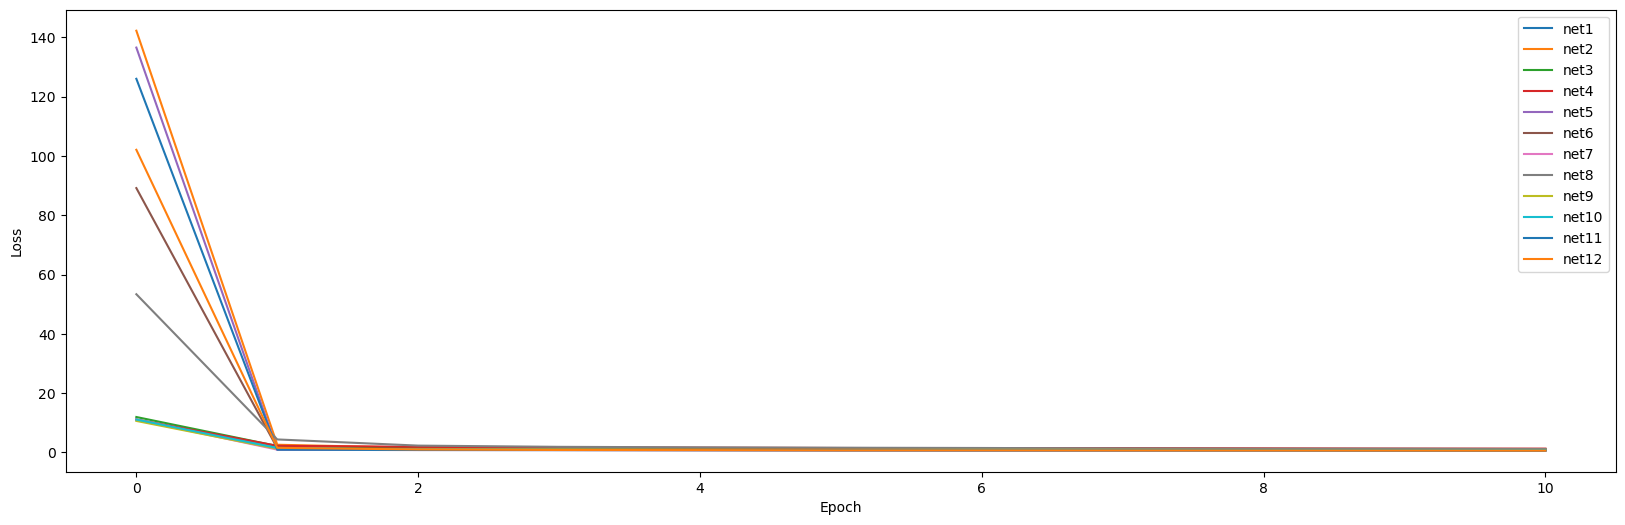

Results after 10 epochs:

Position 1: net11 - loss = 0.582
Position 2: net5 - loss = 0.598
Position 3: net12 - loss = 0.607
Position 4: net7 - loss = 0.725
Position 5: net10 - loss = 0.75
Position 6: net6 - loss = 0.762
Position 7: net2 - loss = 0.802
Position 8: net9 - loss = 0.826
Position 9: net1 - loss = 0.867
Position 10: net3 - loss = 1.091
Position 11: net8 - loss = 1.163
Position 12: net4 - loss = 1.288


In [38]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(loss_val_hist1,label='net1')
plt.plot(loss_val_hist2,label='net2')
plt.plot(loss_val_hist3,label='net3')
plt.plot(loss_val_hist4,label='net4')
plt.plot(loss_val_hist5,label='net5')
plt.plot(loss_val_hist6,label='net6')
plt.plot(loss_val_hist7,label='net7')
plt.plot(loss_val_hist8,label='net8')
plt.plot(loss_val_hist9,label='net9')
plt.plot(loss_val_hist10,label='net10')
plt.plot(loss_val_hist11,label='net11')
plt.plot(loss_val_hist12,label='net12')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

last_loss_values = []
for i in range(1,13):
    
    loss_val = globals().get(f'loss_val_hist{i}')
    last_loss_val = [value for value in loss_val if value is not None][-1]
    last_loss_values.append(last_loss_val)

best_loss = np.argsort(last_loss_values)        

print(f'Results after {num_epochs} epochs:\n')
for ind,index in enumerate(best_loss):
    loss_value = last_loss_values[index]
    
    print(f'Position {ind+1}: net{index+1} - loss = {round(loss_value,3)}')

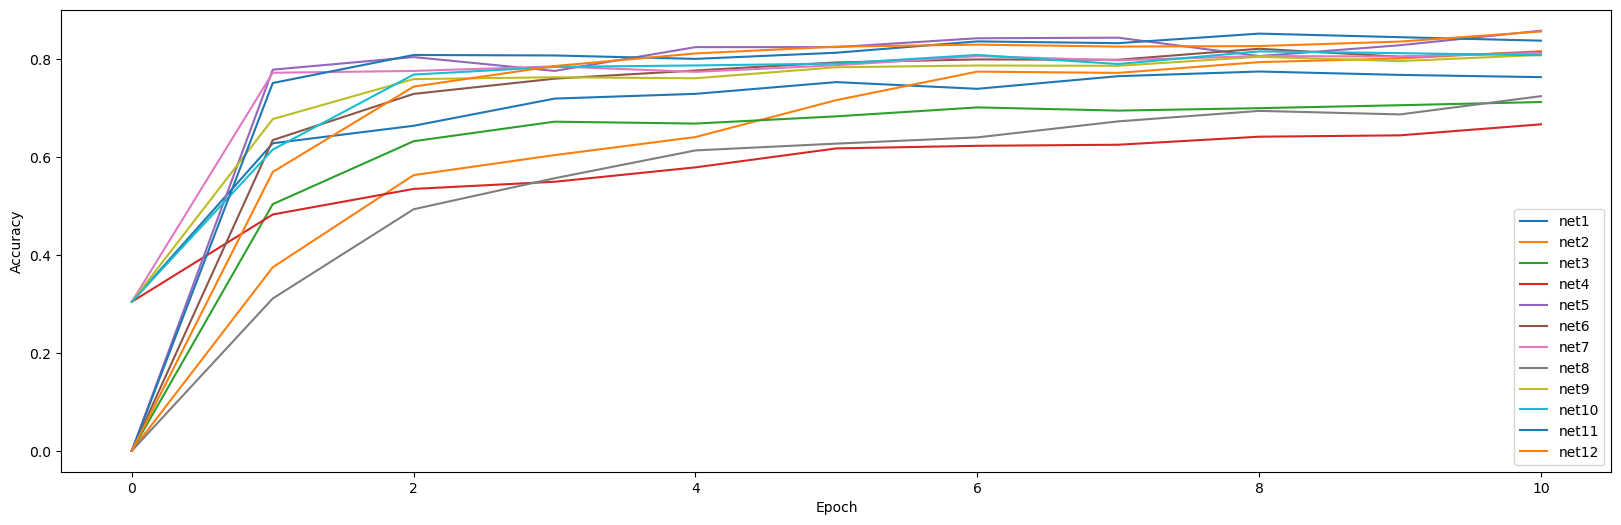

Results after 10 epochs:

Position 1: net5 - accuracy = 85.76%
Position 2: net12 - accuracy = 85.6%
Position 3: net11 - accuracy = 83.73%
Position 4: net2 - accuracy = 81.58%
Position 5: net6 - accuracy = 81.34%
Position 6: net7 - accuracy = 81.23%
Position 7: net9 - accuracy = 80.82%
Position 8: net10 - accuracy = 80.75%
Position 9: net1 - accuracy = 76.28%
Position 10: net8 - accuracy = 72.4%
Position 11: net3 - accuracy = 71.2%
Position 12: net4 - accuracy = 66.65%


In [39]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(acc_val_hist1,label='net1')
plt.plot(acc_val_hist2,label='net2')
plt.plot(acc_val_hist3,label='net3')
plt.plot(acc_val_hist4,label='net4')
plt.plot(acc_val_hist5,label='net5')
plt.plot(acc_val_hist6,label='net6')
plt.plot(acc_val_hist7,label='net7')
plt.plot(acc_val_hist8,label='net8')
plt.plot(acc_val_hist9,label='net9')
plt.plot(acc_val_hist10,label='net10')
plt.plot(acc_val_hist11,label='net11')
plt.plot(acc_val_hist12,label='net12')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

last_acc_values = []
for i in range(1,13):
    
    acc_val = globals().get(f'acc_val_hist{i}')
    last_acc_val = [value for value in acc_val if value is not None][-1]
    last_acc_values.append(last_acc_val)

best_acc = np.argsort(last_acc_values) [::-1]       

print(f'Results after {num_epochs} epochs:\n')
for ind,index in enumerate(best_acc):
    acc_value = last_acc_values[index]
    
    print(f'Position {ind+1}: net{index+1} - accuracy = {round(torch.Tensor.numpy(acc_value)*100,3)}%')

### Batch analysis

In [40]:
batch_size1 = 50
batch_size2 = 100
batch_size3 = 2000
nw=0

train_loader1 = DataLoader(train_dataset, batch_size=batch_size1, shuffle=True, num_workers=nw)
test_loader1  = DataLoader(test_dataset,  batch_size=batch_size1, shuffle=False, num_workers=nw)
val_loader1   = DataLoader(val_dataset,   batch_size=batch_size1, shuffle=False, num_workers=nw)

train_loader2 = DataLoader(train_dataset, batch_size=batch_size2, shuffle=True, num_workers=nw)
test_loader2  = DataLoader(test_dataset,  batch_size=batch_size2, shuffle=False, num_workers=nw)
val_loader2   = DataLoader(val_dataset,   batch_size=batch_size2, shuffle=False, num_workers=nw)

train_loader3 = DataLoader(train_dataset, batch_size=batch_size3, shuffle=True, num_workers=nw)
test_loader3  = DataLoader(test_dataset,  batch_size=batch_size3, shuffle=False, num_workers=nw)
val_loader3   = DataLoader(val_dataset,   batch_size=batch_size3, shuffle=False, num_workers=nw)

##### Net8 (Synaptic 3 Layers)

In [41]:
net8_batch1 = Net_Syn_3L(num_inputs, num_hidden2, num_outputs, num_steps,
                         learn8, beta2, threshold2, alpha2).to(device)
optimizer8_batch1 = torch.optim.Adam(net8_batch1.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist8_batch1, loss_val_hist8_batch1, acc_val_hist8_batch1 = train_net(net8_batch1,
                                                                           train_loader1, val_loader1,
                                                                           num_epochs, loss_fn, optimizer8_batch1,
                                                                           accuracy_type, num_steps, batch_size1,
                                                                           True, False, False)

Validation Set Loss: 144.0494640350342
Validation Set Accuracy: 0.00%

--------------------------------------------------

Epoch: 1
Batch: 0
Iteration: 0
Loss: 143.01803588867188 

Epoch: 1
Batch: 50
Iteration: 50
Loss: 48.207759857177734 

Epoch: 1
Batch: 100
Iteration: 100
Loss: 33.36531448364258 

Epoch: 1
Batch: 150
Iteration: 150
Loss: 7.40253210067749 

Epoch: 1
Batch: 200
Iteration: 200
Loss: 6.51681661605835 

Epoch: 1
Batch: 250
Iteration: 250
Loss: 6.282448768615723 

Epoch: 1
Batch: 300
Iteration: 300
Loss: 5.7230730056762695 

Epoch: 1
Batch: 350
Iteration: 350
Loss: 5.173901081085205 

Epoch: 1
Batch: 400
Iteration: 400
Loss: 4.804509162902832 

Epoch: 1
Batch: 450
Iteration: 450
Loss: 5.150655746459961 

Epoch: 1
Batch: 500
Iteration: 500
Loss: 3.954617977142334 

Epoch: 1
Batch: 550
Iteration: 550
Loss: 3.4622907638549805 

Epoch: 1
Batch: 600
Iteration: 600
Loss: 3.4318788051605225 

Epoch: 1
Batch: 650
Iteration: 650
Loss: 3.2097153663635254 

Epoch: 1
Batch: 700
Itera

In [42]:
net8_batch2 = Net_Syn_3L(num_inputs, num_hidden2, num_outputs, num_steps,
                         learn8, beta2, threshold2, alpha2).to(device)
optimizer8_batch2 = torch.optim.Adam(net8_batch2.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist8_batch2, loss_val_hist8_batch2, acc_val_hist8_batch2 = train_net(net8_batch2,
                                                                           train_loader2, val_loader2,
                                                                           num_epochs, loss_fn, optimizer8_batch2,
                                                                           accuracy_type, num_steps, batch_size2,
                                                                           True, False, False)

Validation Set Loss: 168.66307373046874
Validation Set Accuracy: 0.00%

--------------------------------------------------

Epoch: 1
Batch: 0
Iteration: 0
Loss: 169.51954650878906 

Epoch: 1
Batch: 50
Iteration: 50
Loss: 45.82421112060547 

Epoch: 1
Batch: 100
Iteration: 100
Loss: 10.148686408996582 

Epoch: 1
Batch: 150
Iteration: 150
Loss: 8.330552101135254 

Epoch: 1
Batch: 200
Iteration: 200
Loss: 7.160253047943115 

Epoch: 1
Batch: 250
Iteration: 250
Loss: 6.467219829559326 

Epoch: 1
Batch: 300
Iteration: 300
Loss: 5.649011135101318 

Epoch: 1
Batch: 350
Iteration: 350
Loss: 6.221677780151367 

Epoch: 1
Batch: 400
Iteration: 400
Loss: 5.598757266998291 

Epoch: 1
Batch: 450
Iteration: 450
Loss: 5.244624614715576 

Epoch: 1
Batch: 500
Iteration: 500
Loss: 5.807049751281738 

Epoch: 1
Batch: 550
Iteration: 550
Loss: 5.253430366516113 

Epoch: 1
Batch: 600
Iteration: 600
Loss: 5.01455545425415 

Epoch: 1
Batch: 650
Iteration: 650
Loss: 4.661957263946533 

Epoch: 1
Batch: 700
Iterati

In [43]:
net8_batch3 = Net_Syn_3L(num_inputs, num_hidden2, num_outputs, num_steps,
                         learn8, beta2, threshold2, alpha2).to(device)
optimizer8_batch3 = torch.optim.Adam(net8_batch3.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist8_batch3, loss_val_hist8_batch3, acc_val_hist8_batch3 = train_net(net8_batch3,
                                                                           train_loader3, val_loader3,
                                                                           num_epochs, loss_fn, optimizer8_batch3,
                                                                           accuracy_type, num_steps, batch_size3,
                                                                           True, False, False)

Validation Set Loss: 123.82967681884766
Validation Set Accuracy: 0.00%

--------------------------------------------------

Epoch: 1
Batch: 0
Iteration: 0
Loss: 123.8946762084961 

Validation Set Loss: 10.758907318115234
Validation Set Accuracy: 24.48%

--------------------------------------------------

Epoch: 2
Batch: 0
Iteration: 50
Loss: 10.6934814453125 

Validation Set Loss: 7.725761795043946
Validation Set Accuracy: 26.03%

--------------------------------------------------

Epoch: 3
Batch: 0
Iteration: 100
Loss: 7.800161838531494 

Validation Set Loss: 6.629614925384521
Validation Set Accuracy: 27.07%

--------------------------------------------------

Epoch: 4
Batch: 0
Iteration: 150
Loss: 6.694459438323975 

Validation Set Loss: 5.711110687255859
Validation Set Accuracy: 26.66%

--------------------------------------------------

Epoch: 5
Batch: 0
Iteration: 200
Loss: 5.697954177856445 

Validation Set Loss: 5.29901819229126
Validation Set Accuracy: 26.93%

-----------------

In [44]:
for i in range(1,4):
    csv_file_path = f'results/batch_test/output_net8_{i}.csv'
    net_name = f'results/nets_2ndTask/BatchSize/net_8_{i}'
    
    net = globals().get(f'net8_batch{i}')
    
    loss_train = globals().get(f'loss_hist8_batch{i}')
    loss_val = globals().get(f'loss_val_hist8_batch{i}')
    acc = globals().get(f'acc_val_hist8_batch{i}')
    
    # Find the maximum length among the arrays
    max_length = max(len(loss_train), len(loss_val), len(acc))

    # Fill missing values with None
    loss_train += [None] * (max_length - len(loss_train))
    loss_val += [None] * (max_length - len(loss_val))
    acc += [None] * (max_length - len(acc))
    
    rows = list(zip(loss_train, loss_val, acc))
    
    # Write the data to a CSV file
    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
    
        # Write the header
        writer.writerow(['LossTrain', 'LossVal', 'Accuracy'])
    
        # Write the data
        writer.writerows(rows)

    print(f'CSV file "{csv_file_path}" created successfully.')
    torch.save(net.state_dict(), net_name)

CSV file "results/batch_test/output_net8_1.csv" created successfully.
CSV file "results/batch_test/output_net8_2.csv" created successfully.
CSV file "results/batch_test/output_net8_3.csv" created successfully.


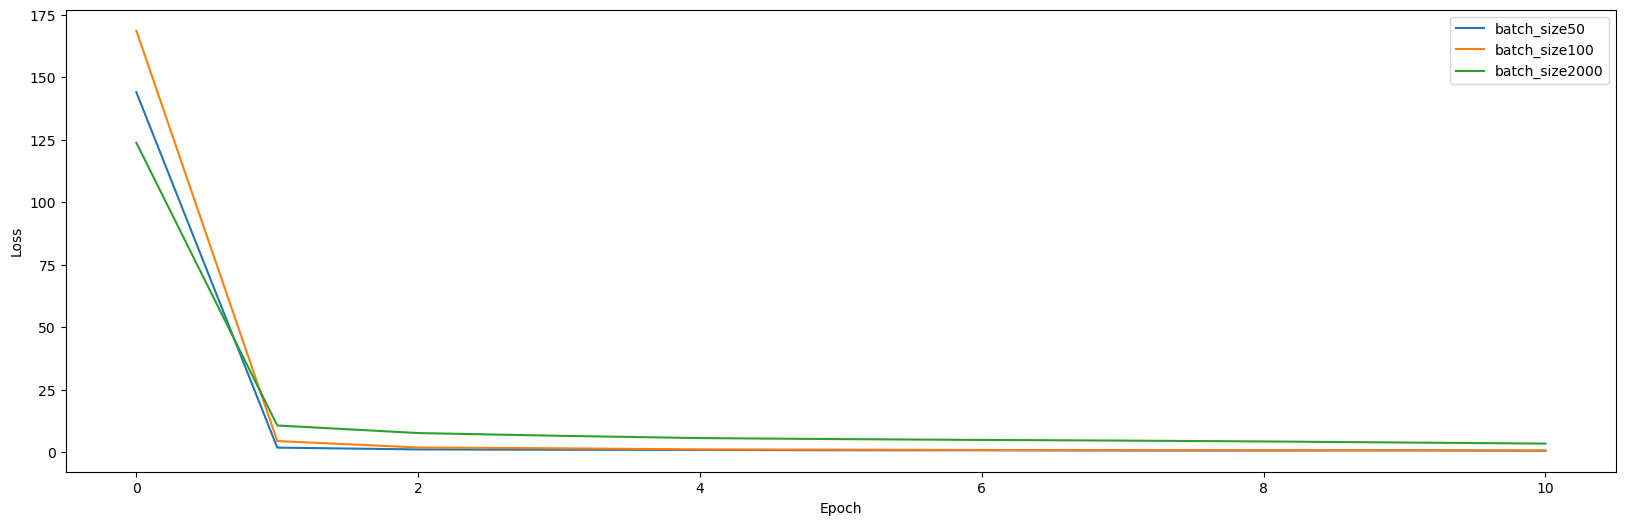

Results after 10 epochs:

Position 1: net1 - loss = 0.657
Position 2: net2 - loss = 0.776
Position 3: net3 - loss = 3.507


In [45]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(loss_val_hist8_batch1,label='batch_size50')
plt.plot(loss_val_hist8_batch2,label='batch_size100')
plt.plot(loss_val_hist8_batch3,label='batch_size2000')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

last_loss_values = []
for i in range(1,4):
    
    loss_val = globals().get(f'loss_val_hist8_batch{i}')
    last_loss_val = [value for value in loss_val if value is not None][-1]
    last_loss_values.append(last_loss_val)

best_loss = np.argsort(last_loss_values)        

print(f'Results after {num_epochs} epochs:\n')
for ind,index in enumerate(best_loss):
    loss_value = last_loss_values[index]
    
    print(f'Position {ind+1}: net{index+1} - loss = {round(loss_value,3)}')

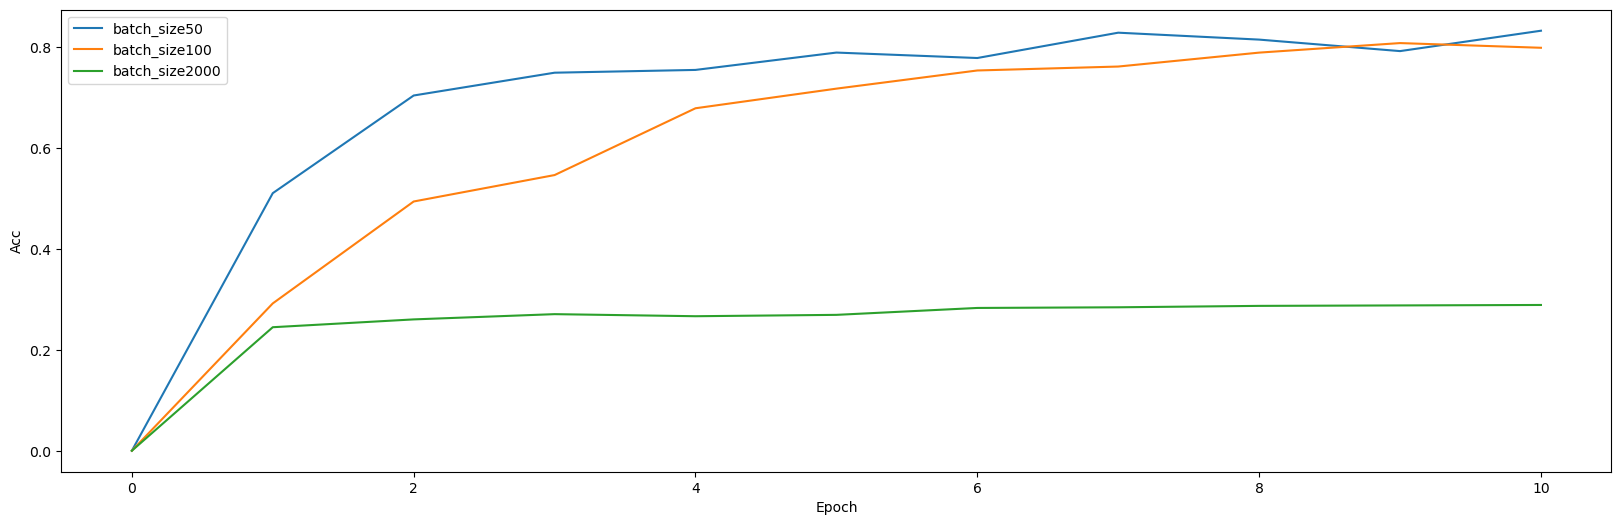

Results after 10 epochs:

Position 1: net1 - accuracy = 83.25%
Position 2: net2 - accuracy = 79.87%
Position 3: net3 - accuracy = 28.89%


In [46]:
# Plot Acc
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(acc_val_hist8_batch1,label='batch_size50')
plt.plot(acc_val_hist8_batch2,label='batch_size100')
plt.plot(acc_val_hist8_batch3,label='batch_size2000')
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.legend()
plt.show()

last_acc_values = []
for i in range(1,4):
    
    acc_val = globals().get(f'acc_val_hist8_batch{i}')
    last_acc_val = [value for value in acc_val if value is not None][-1]
    last_acc_values.append(last_acc_val)

best_acc = np.argsort(last_acc_values) [::-1]       

print(f'Results after {num_epochs} epochs:\n')
for ind,index in enumerate(best_acc):
    acc_value = last_acc_values[index]
    
    print(f'Position {ind+1}: net{index+1} - accuracy = {round(torch.Tensor.numpy(acc_value)*100,3)}%')

##### Net11 (Synaptic 1 Layer)

In [47]:
net11_batch1 = Net_Syn_1L(num_inputs, num_hidden5, num_outputs, num_steps,
                          learn11, beta5, threshold5).to(device)
optimizer11_batch1 = torch.optim.Adam(net11_batch1.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist11_batch1, loss_val_hist11_batch1, acc_val_hist11_batch1 = train_net(net11_batch1,
                                                                              train_loader1, val_loader1,
                                                                              num_epochs, loss_fn, optimizer11_batch1,
                                                                              accuracy_type, num_steps, batch_size1,
                                                                              True, False, False)

Validation Set Loss: 106.83619533538818
Validation Set Accuracy: 0.00%

--------------------------------------------------

Epoch: 1
Batch: 0
Iteration: 0
Loss: 109.91279602050781 

Epoch: 1
Batch: 50
Iteration: 50
Loss: 7.621983051300049 

Epoch: 1
Batch: 100
Iteration: 100
Loss: 5.159348964691162 

Epoch: 1
Batch: 150
Iteration: 150
Loss: 4.503144264221191 

Epoch: 1
Batch: 200
Iteration: 200
Loss: 4.156585693359375 

Epoch: 1
Batch: 250
Iteration: 250
Loss: 3.0545129776000977 

Epoch: 1
Batch: 300
Iteration: 300
Loss: 2.337653160095215 

Epoch: 1
Batch: 350
Iteration: 350
Loss: 2.6673829555511475 

Epoch: 1
Batch: 400
Iteration: 400
Loss: 2.7961788177490234 

Epoch: 1
Batch: 450
Iteration: 450
Loss: 1.748334288597107 

Epoch: 1
Batch: 500
Iteration: 500
Loss: 1.5992772579193115 

Epoch: 1
Batch: 550
Iteration: 550
Loss: 1.9160016775131226 

Epoch: 1
Batch: 600
Iteration: 600
Loss: 1.5638459920883179 

Epoch: 1
Batch: 650
Iteration: 650
Loss: 1.6373450756072998 

Epoch: 1
Batch: 700


In [48]:
net11_batch2 = Net_Syn_1L(num_inputs, num_hidden5, num_outputs, num_steps,
                          learn11, beta5, threshold5).to(device)
optimizer11_batch2 = torch.optim.Adam(net11_batch2.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist11_batch2, loss_val_hist11_batch2, acc_val_hist11_batch2 = train_net(net11_batch2,
                                                                              train_loader2, val_loader2,
                                                                              num_epochs, loss_fn, optimizer11_batch2,
                                                                              accuracy_type, num_steps, batch_size2,
                                                                              True, False, False)

Validation Set Loss: 124.17716232299804
Validation Set Accuracy: 0.00%

--------------------------------------------------

Epoch: 1
Batch: 0
Iteration: 0
Loss: 127.32720947265625 

Epoch: 1
Batch: 50
Iteration: 50
Loss: 7.722356796264648 

Epoch: 1
Batch: 100
Iteration: 100
Loss: 5.436309337615967 

Epoch: 1
Batch: 150
Iteration: 150
Loss: 4.217471122741699 

Epoch: 1
Batch: 200
Iteration: 200
Loss: 3.274080991744995 

Epoch: 1
Batch: 250
Iteration: 250
Loss: 2.929201126098633 

Epoch: 1
Batch: 300
Iteration: 300
Loss: 2.33742094039917 

Epoch: 1
Batch: 350
Iteration: 350
Loss: 1.9547770023345947 

Epoch: 1
Batch: 400
Iteration: 400
Loss: 1.6888991594314575 

Epoch: 1
Batch: 450
Iteration: 450
Loss: 1.7409135103225708 

Epoch: 1
Batch: 500
Iteration: 500
Loss: 1.2677608728408813 

Epoch: 1
Batch: 550
Iteration: 550
Loss: 1.9330832958221436 

Epoch: 1
Batch: 600
Iteration: 600
Loss: 1.3813022375106812 

Epoch: 1
Batch: 650
Iteration: 650
Loss: 1.2130908966064453 

Epoch: 1
Batch: 700
I

In [49]:
net11_batch3 = Net_Syn_1L(num_inputs, num_hidden5, num_outputs, num_steps,
                          learn11, beta5, threshold5).to(device)
optimizer11_batch3 = torch.optim.Adam(net11_batch3.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist11_batch3, loss_val_hist11_batch3, acc_val_hist11_batch3 = train_net(net11_batch3,
                                                                              train_loader3, val_loader3,
                                                                              num_epochs, loss_fn, optimizer11_batch3,
                                                                              accuracy_type, num_steps, batch_size3,
                                                                              True, False, False)

Validation Set Loss: 153.52588806152343
Validation Set Accuracy: 0.00%

--------------------------------------------------

Epoch: 1
Batch: 0
Iteration: 0
Loss: 153.87059020996094 

Validation Set Loss: 7.366482067108154
Validation Set Accuracy: 28.00%

--------------------------------------------------

Epoch: 2
Batch: 0
Iteration: 50
Loss: 7.4701948165893555 

Validation Set Loss: 5.258307075500488
Validation Set Accuracy: 29.74%

--------------------------------------------------

Epoch: 3
Batch: 0
Iteration: 100
Loss: 5.321835994720459 

Validation Set Loss: 4.399929714202881
Validation Set Accuracy: 29.55%

--------------------------------------------------

Epoch: 4
Batch: 0
Iteration: 150
Loss: 4.357681751251221 

Validation Set Loss: 3.3346620082855223
Validation Set Accuracy: 28.04%

--------------------------------------------------

Epoch: 5
Batch: 0
Iteration: 200
Loss: 3.330742359161377 

Validation Set Loss: 2.725284051895142
Validation Set Accuracy: 27.50%

-------------

In [50]:
for i in range(1,4):
    csv_file_path = f'results/batch_test/output_net11_{i}.csv'
    net_name = f'results/nets_2ndTask/BatchSize/net_11_{i}'
    
    net = globals().get(f'net11_batch{i}')
    
    loss_train = globals().get(f'loss_hist11_batch{i}')
    loss_val = globals().get(f'loss_val_hist11_batch{i}')
    acc = globals().get(f'acc_val_hist11_batch{i}')
    
    # Find the maximum length among the arrays
    max_length = max(len(loss_train), len(loss_val), len(acc))

    # Fill missing values with None
    loss_train += [None] * (max_length - len(loss_train))
    loss_val += [None] * (max_length - len(loss_val))
    acc += [None] * (max_length - len(acc))
    
    rows = list(zip(loss_train, loss_val, acc))
    
    # Write the data to a CSV file
    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
    
        # Write the header
        writer.writerow(['LossTrain', 'LossVal', 'Accuracy'])
    
        # Write the data
        writer.writerows(rows)

    print(f'CSV file "{csv_file_path}" created successfully.')
    torch.save(net.state_dict(), net_name)

CSV file "results/batch_test/output_net11_1.csv" created successfully.
CSV file "results/batch_test/output_net11_2.csv" created successfully.
CSV file "results/batch_test/output_net11_3.csv" created successfully.


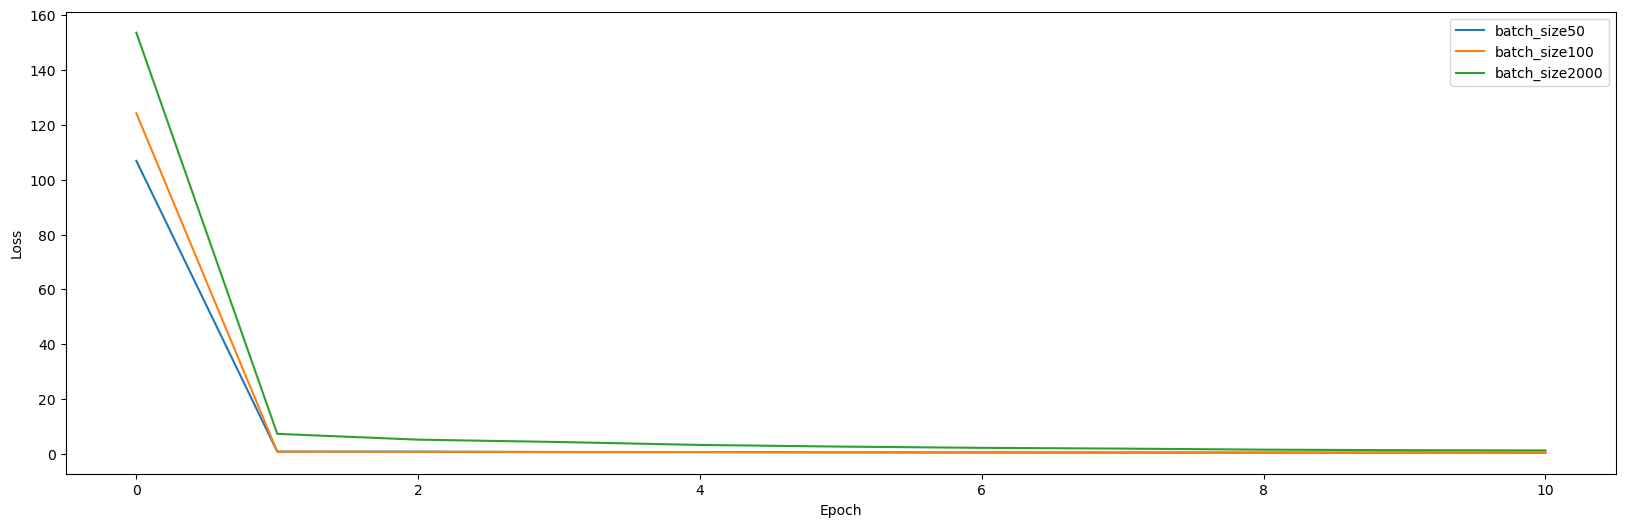

Results after 10 epochs:

Position 1: net1 - loss = 0.497
Position 2: net2 - loss = 0.545
Position 3: net3 - loss = 1.327


In [51]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(loss_val_hist11_batch1,label='batch_size50')
plt.plot(loss_val_hist11_batch2,label='batch_size100')
plt.plot(loss_val_hist11_batch3,label='batch_size2000')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

last_loss_values = []
for i in range(1,4):
    
    loss_val = globals().get(f'loss_val_hist11_batch{i}')
    last_loss_val = [value for value in loss_val if value is not None][-1]
    last_loss_values.append(last_loss_val)

best_loss = np.argsort(last_loss_values)        

print(f'Results after {num_epochs} epochs:\n')
for ind,index in enumerate(best_loss):
    loss_value = last_loss_values[index]
    
    print(f'Position {ind+1}: net{index+1} - loss = {round(loss_value,3)}')

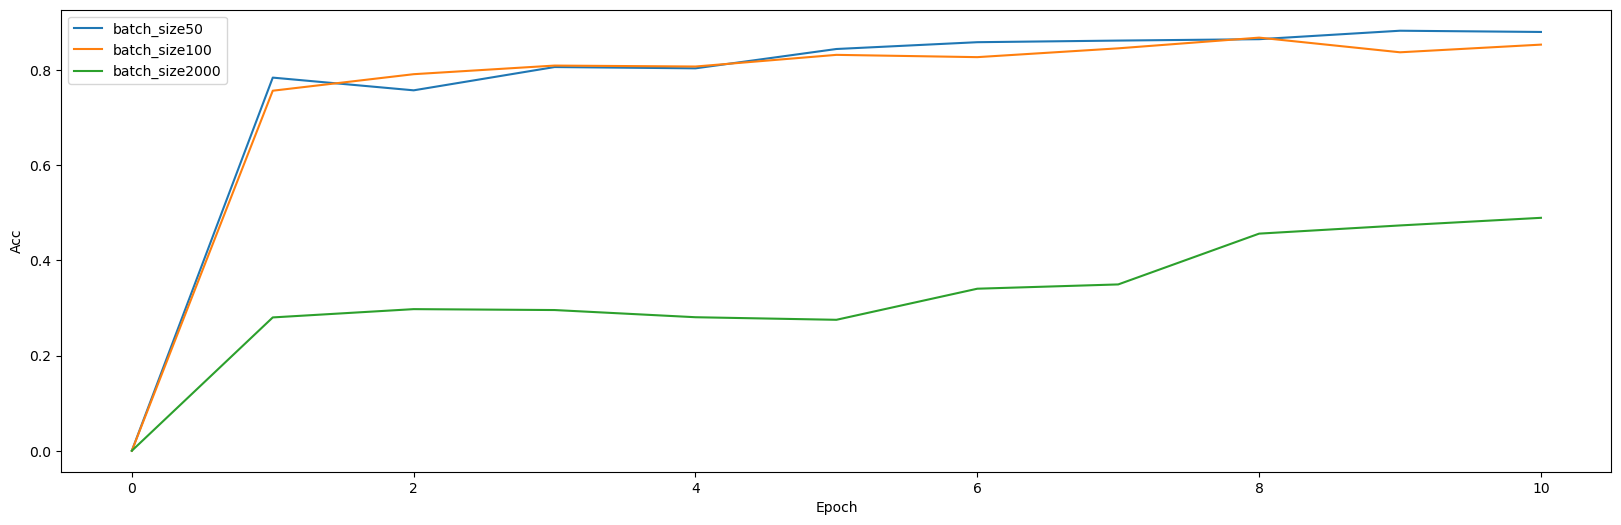

Results after 10 epochs:

Position 1: net1 - acuracy = 87.96%
Position 2: net2 - acuracy = 85.3%
Position 3: net3 - acuracy = 48.92%


In [52]:
# Plot Acc
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(acc_val_hist11_batch1,label='batch_size50')
plt.plot(acc_val_hist11_batch2,label='batch_size100')
plt.plot(acc_val_hist11_batch3,label='batch_size2000')
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.legend()
plt.show()

last_acc_values = []
for i in range(1,4):
    
    acc_val = globals().get(f'acc_val_hist11_batch{i}')
    last_acc_val = [value for value in acc_val if value is not None][-1]
    last_acc_values.append(last_acc_val)

best_acc = np.argsort(last_acc_values) [::-1]       

print(f'Results after {num_epochs} epochs:\n')
for ind,index in enumerate(best_acc):
    acc_value = last_acc_values[index]
    
    print(f'Position {ind+1}: net{index+1} - acuracy = {round(torch.Tensor.numpy(acc_value)*100,3)}%')